## Simulazione della fase gassosa $\rho = 0.05 \,, T = 1.2 

In [5]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import math
from scipy.optimize import curve_fit

def myexp(x, a):
    return np.exp(-x/a) 
def plaw(x, b):
    return (x)**(-b)

### Funzioni di Autocorrelazione

In [6]:
obs = [np.loadtxt("Istantaneous/epot_gas.dat"),
       np.loadtxt("Istantaneous/pres_gas.dat")]

N = len(obs[0])
n = N//2000

afs = [np.zeros(n), np.zeros(n)]

d = np.zeros(4)
for i in range(N):
    d[0] += obs[0][i]**2/N 
    d[1] += obs[0][i]/N
    d[2] += obs[1][i]**2/N 
    d[3] += obs[1][i]/N

D = [d[0] - d[1]**2, d[2] - d[3]**2] 

for i in range(n):
    x = [0,0]
    y = [0,0]
    z = [0,0]
    for j in range(N-i):
        for k in range(2):
            x[k] += obs[k][j]*obs[k][j+i]/(N-i)
            y[k] += obs[k][j]/(N-i)
            z[k] += obs[k][j+i]/(N-i)
    afs[0][i] = (x[0] - y[0] * z[0])/D[0]    
    afs[1][i] = (x[1] - y[1] * z[1])/D[1]


/home/alessandro/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in log


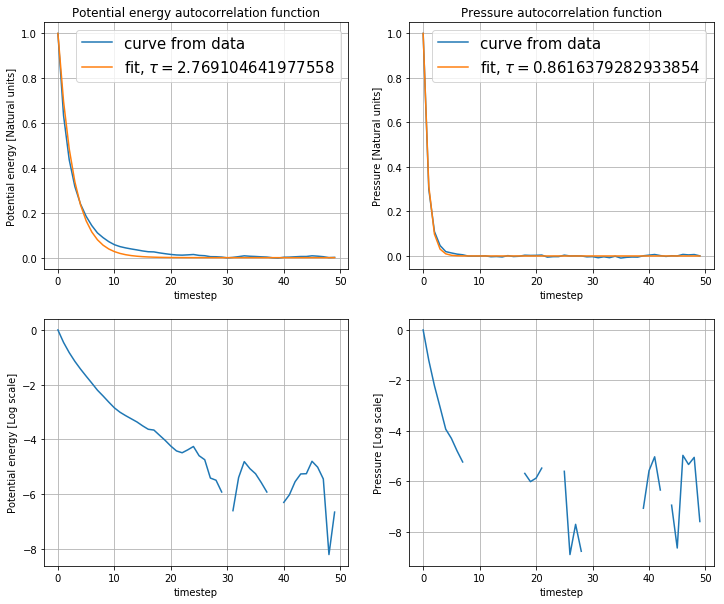

In [7]:
t = np.arange(n)
f = plt.figure(figsize = (12, 10))
text = ['Potential energy', 'Pressure']

for i in range(2):
    f.add_subplot(2, 2, 1+i)
    plt.plot(t, afs[i], label = 'curve from data')
    p_opt, p_cov = curve_fit(myexp, t, afs[i]) 
    y_fit = myexp(t,p_opt[0])
    tau = str(p_opt[0])
    plt.plot(t, y_fit, label = 'fit, $ \u03C4 = $' + tau)
    plt.xlabel('timestep')
    plt.ylabel(text[i]+' [Natural units]')
    plt.title(text[i]+' autocorrelation function')
    plt.legend(prop={'size': 15})
    plt.grid()

    
for i in range(2):
    f.add_subplot(2, 2, 3+i)
    plt.plot(t, np.log(afs[i]), label = 'curve from data')
    plt.xlabel('timestep')
    plt.ylabel(text[i]+' [Log scale]')
    plt.grid()


È interessante vedere come nel gas le correlazioni diventino compatibili con lo 0 prestissimo, a differenza di solido e liquido.

### Data blocking

In [8]:
dim = 29

dim_blk = np.zeros(dim)
num_blk = np.zeros(dim)
dix = np.zeros(36)

for i in range(6):                   # Ho un totale di 100000 misure da dividere in blocchi
    for j in range(6):               # Creo l'array di tutti i divisori di 100000
        dix[6*i + j] = (2**j)*(5**i) 

dix.sort()                           # Ordino l'array
for i in range(dim):
        dim_blk[i] = dix[i]           # Creo un array con tutti i divisori meno
        num_blk[i] = int(N/dim_blk[i])  # 1 e 100000 (dimensioni critiche del blocco)
                                        # Così facendo ora ho blocchi
err = [np.zeros(dim), np.zeros(dim)]

for i in range(dim):
    ave_obs = [np.zeros(int(num_blk[i])), np.zeros(int(num_blk[i]))] #aggiorno a 0 le medie
    ave2 = [0,0]                                                     # nei blocchi
    ave = [0,0]
    for j in range(int(num_blk[i])):
        for k in range(int(j*dim_blk[i]), int((j+1)*dim_blk[i])):    
            ave_obs[0][j] += obs[0][k]/dim_blk[i]           #calcolo il valor medio     
            ave_obs[1][j] += obs[1][k]/dim_blk[i]           # all'interno di un blocco
        ave2[0] += (ave_obs[0][j]**2)/num_blk[i]          # calcolo media e varianza 
        ave[0] += ave_obs[0][j]/num_blk[i]                # dei blocchi
        ave2[1] += (ave_obs[1][j]**2)/num_blk[i]
        ave[1] += ave_obs[1][j]/num_blk[i]
    err[1][i] = np.sqrt((ave2[1] - ave[1]**2)/num_blk[i])  #aggiorno il valore 
    err[0][i] = np.sqrt((ave2[0] - ave[0]**2)/num_blk[i])  #dell'incertezza statistica


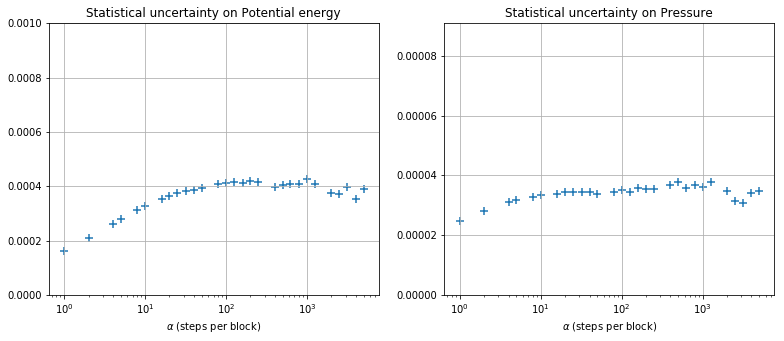

In [9]:
f = plt.figure(figsize = (13, 5))   
text = ['Potential energy', 'Pressure']
for i in range(2):
    f.add_subplot(1, 2, 1+i)          
    plt.scatter((dim_blk), err[i], s = 50, marker = '+')
    plt.ylim(0, 0.001/(i*10+1))
    plt.xscale('log')
    plt.xlabel('$ \u03B1$ (steps per block)')
    plt.title('Statistical uncertainty on ' + text[i])
    plt.grid()
    
#plt.tight_layout()

Anche in questo caso quello che impariamo dallo studio dell'errore è complementare rispetto a quello che abbiamo scoperto sulle correlazioni: soprattutto nel grafico didestra si nota che l'errore si è stabilizzato già dopo 10 step MC.

Anche nel caso del gas comunque scegliamo come dimensione dei blocchi $200$ step MC.

In [51]:
d = 200
num = 10**5//d

###  Argon e Krypton in fase gassosa

In [59]:
amu = 1.6605 * 10**(-27)   #kilograms
k_B = 1.38065 * 10**(-23)  #Joules/Kelvin

sigma_Ar = 0.34*10**(-9)      #meters
epsilon_Ar = 120 * k_B        #Joules
m_Ar = 39.948 * amu           #kilograms

sigma_Kr = 0.364*10**(-9)      #meters
epsilon_Kr = 164 * k_B        #Joules
m_Kr = 83.798 * amu            #kilograms

In [55]:
ave_blk = [0, 0]
accum = [0,0]
accum2 = [0,0]

ave = [np.zeros(num), np.zeros(num)]
ave2 = [np.zeros(num), np.zeros(num)]
devstd = [np.zeros(num), np.zeros(num)]

t = np.arange(num)

for i in range(num):
    ave_blk = [0, 0]
    for k in range(i*d, (i+1)*d):    
        ave_blk[0] += obs[0][k]/d          #calcolo il valor medio     
        ave_blk[1] += obs[1][k]/d         # all'interno di un blocco
    accum[0] += ave_blk[0]
    accum[1] += ave_blk[1]
    accum2[0] += ave_blk[0]**2
    accum2[1] += ave_blk[1]**2
    ave[0][i] = accum[0]/(i+1)               # dei blocchi
    ave[1][i] = accum[1]/(i+1)
    devstd[0][i] = np.sqrt((accum2[0]/(i+1) - (accum[0]/(i+1))**2)/(i+1))  #aggiorno il valore 
    devstd[1][i] = np.sqrt((accum2[1]/(i+1) - (accum[1]/(i+1))**2)/(i+1))  #aggiorno il valore 


(U)Natural units: -0.4148200649510001 +/- 0.0004204790236805159
(P)Natural units: 0.04899590401599997 +/- 3.5325554250899325e-05


ARGON: ρ =  1.9652000000000015e-30 m^(-3),   T =  144.0 K
(U) SI units: -6.872655872095178e-22 +/- 6.96641236853405e-25 J
(P) SI units: 2065322.457145033 +/- 1489.0767293864476 Pa


KRYPTON: ρ =  2.4114272000000005e-30 m^(-3),   T =  196.8 K
(U) SI units: -9.39262969186341e-22 +/- 9.520763570329869e-25 J
(P) SI units: 2300292.532212711 +/- 1658.4877914097258 Pa


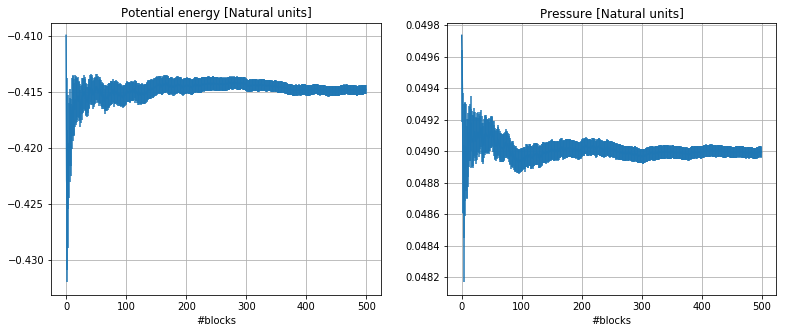

In [61]:
f = plt.figure(figsize = (13, 5))   
text = ['Potential energy', 'Pressure']
for i in range(2):
    f.add_subplot(1, 2, 1+i)          
    plt.errorbar(t, ave[i], devstd[i])
    plt.xlabel('#blocks')
    plt.title(text[i]+' [Natural units]')
    plt.grid()

print("(U)Natural units:", ave[0][num-1], "+/-", devstd[0][num-1])
print("(P)Natural units:", ave[1][num-1], "+/-", devstd[1][num-1])

print("\n")
print ("ARGON: \u03C1 = ", 0.05/sigma_Ar**(-3),"m^(-3), ",    
      " T = " , 1.2*epsilon_Ar/k_B, "K")
print("(U) SI units:", ave[0][num-1] * epsilon_Ar, "+/-" ,
      devstd[0][num-1] * epsilon_Ar, "J")
print("(P) SI units:", ave[1][num-1] * epsilon_Ar/sigma_Ar**3, "+/-" ,
      devstd[1][num-1] * epsilon_Ar/sigma_Ar**3, "Pa")

print("\n")
print ("KRYPTON: \u03C1 = ", 0.05/sigma_Kr**(-3),"m^(-3), ",    
      " T = " , 1.2*epsilon_Kr/k_B, "K")
print("(U) SI units:", ave[0][num-1] * epsilon_Kr, "+/-" ,
      devstd[0][num-1] * epsilon_Kr, "J")
print("(P) SI units:", ave[1][num-1] * epsilon_Kr/sigma_Kr**3, "+/-" ,
      devstd[1][num-1]* epsilon_Kr/sigma_Kr**3, "Pa")


### Funzione di distribuzione radiale

Text(0.5, 1.0, 'Radial distribution function')

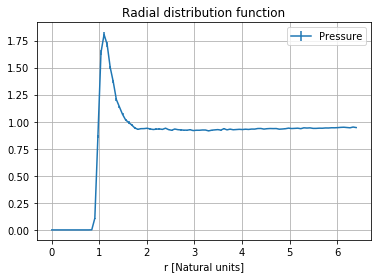

In [10]:
r, gdr, err_gdr = np.loadtxt("RadFunc/Gas/output.gave.0", usecols = (0, 1, 2), unpack = 'true')
plt.errorbar(r, gdr, err_gdr, label = text[i])
plt.xlabel('r [Natural units]')
plt.legend()
plt.grid()
    
plt.title('Radial distribution function')